# Prepare Data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import Libraries

In [2]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Dropout
from keras.models import Sequential


import pandas as pd
import matplotlib.pyplot as plt
import warnings

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report, ConfusionMatrixDisplay
import re
import string
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
# Ignore FutureWarning messages
warnings.simplefilter(action='ignore', category=FutureWarning)

## Read csv files

In [3]:
df = pd.read_csv('/content/drive/MyDrive/2023-2024/UCL MSc in DSML/Term 2/Advanced ML in Finance/Project/Kaggle/Financial Sentiment Analysis/all-data.csv', names=["Sentiment", "text"],
                 encoding="utf-8", encoding_errors="replace")
df.head()
# print(df.shape)

,Sentiment,text
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


## Data Cleaning and Explore Dataset Analysis

In [4]:
df.info()
df.isnull().sum()
df.duplicated().sum()
df.drop_duplicates(keep='first', inplace=True)
df.info()
# df['Sentiment'] = df['Sentiment'].map({ 'Negative':0, 'Neutral':1, 'Positive':2})
df['Sentiment'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4846 entries, 0 to 4845
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentiment  4846 non-null   object
 1   text       4846 non-null   object
dtypes: object(2)
memory usage: 75.8+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 4840 entries, 0 to 4845
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentiment  4840 non-null   object
 1   text       4840 non-null   object
dtypes: object(2)
memory usage: 113.4+ KB


Sentiment
neutral     2873
positive    1363
negative     604
Name: count, dtype: int64

## Visualization of Data

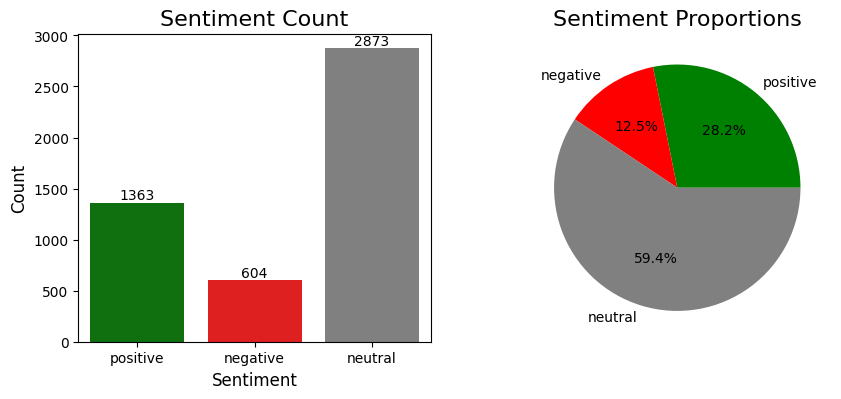

In [5]:
# # Define the order of sentiments
# sentiment_order = ['positive', 'negative', 'neutral']

# # Define the colors for each sentiment
# sentiment_colors = {'positive': 'green', 'negative': 'red', 'neutral': 'grey'}

# # Generate the sentiment count and annotate the specific count at the top of the bars
# sentiment_count = df['Sentiment'].value_counts().reindex(sentiment_order)
# plt.figure(figsize=(10, 6))
# sns.barplot(x=sentiment_count.index, y=sentiment_count.values, palette=sentiment_colors)
# plt.title('Sentiment Count', fontsize=16)
# plt.xlabel('Sentiment', fontsize=12)
# plt.ylabel('Count', fontsize=12)
# for i, count in enumerate(sentiment_count.values):
#     plt.text(i, count, count, ha='center', va='bottom', fontsize=12)
# plt.show()


import matplotlib.pyplot as plt

# Define the order of sentiments
sentiment_order = ['positive', 'negative', 'neutral']

# Define the colors for each sentiment
sentiment_colors = {'positive': 'green', 'negative': 'red', 'neutral': 'grey'}

# Generate the sentiment count
sentiment_count = df['Sentiment'].value_counts().reindex(sentiment_order)

# Create a figure with two subplots: one for the bar chart and one for the pie chart
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Bar chart
sns.barplot(x=sentiment_count.index, y=sentiment_count.values, palette=sentiment_colors, ax=ax[0])
ax[0].set_title('Sentiment Count', fontsize=16)
ax[0].set_xlabel('Sentiment', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
for i, count in enumerate(sentiment_count.values):
    ax[0].text(i, count, count, ha='center', va='bottom', fontsize=10)

# Pie chart
ax[1].pie(sentiment_count.values, labels=sentiment_count.index, colors=[sentiment_colors[i] for i in sentiment_order], autopct='%1.1f%%', textprops={'fontsize': 10})
ax[1].set_title('Sentiment Proportions', fontsize=16)

plt.show()

In [6]:
# # Generate the sentiment proportions and annotate the specific proportion at the top of the bars
# sentiment_proportion = df['Sentiment'].value_counts(normalize=True).reindex(sentiment_order)
# plt.figure(figsize=(10, 6))
# sns.barplot(x=sentiment_proportion.index, y=sentiment_proportion.values, palette=sentiment_colors)
# plt.title('Sentiment Proportion', fontsize=16)
# plt.xlabel('Sentiment', fontsize=12)
# plt.ylabel('Proportion', fontsize=12)
# for i, proportion in enumerate(sentiment_proportion.values):
#     plt.text(i, proportion, f'{proportion:.2%}', ha='center', va='bottom', fontsize=12)
# plt.show()

## Text Preprocessing

In [7]:
# Remove Stopwords
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)

# Clean Text
def clean_text(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = ' '.join(text.split())
    return text

# Stemming
stemmer = SnowballStemmer("english")
def stemming(sentence):
    stemSentence = ""
    for word in sentence.split():
        stem = stemmer.stem(word)
        stemSentence += stem
        stemSentence += " "
    stemSentence = stemSentence.strip()
    return stemSentence

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [8]:
df['text'] = df['text'].astype(str)
df['text'] = df['text'].apply(lambda x: remove_stopwords(x))
df['text'] = df['text'].apply(lambda x: clean_text(x))
df['text'] = df['text'].apply(stemming)

## Create a Word Cloud

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


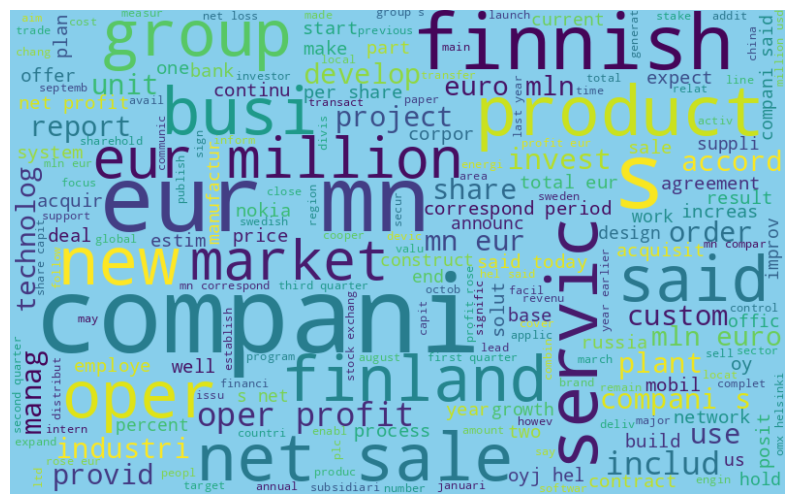

In [9]:
import pandas as pd
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from collections import defaultdict
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')

# # Generate the word frequency
# word_freqs = defaultdict(lambda: defaultdict(int))
# for _, row in df.iterrows():
#     tokens = word_tokenize(row['text'])
#     for token in tokens:
#         word_freqs[row['Sentiment']][token] += 1

# word_sentiment = {}
# for word in set(word for sentiment in word_freqs for word in word_freqs[sentiment]):
#     word_sentiment[word] = max(word_freqs, key=lambda sentiment: word_freqs[sentiment][word])

# # Define a function to color the words
# def color_func(word, **kwargs):
#     sentiment = word_sentiment.get(word, 'neutral')
#     return {'positive': 'green', 'negative': 'red', 'neutral': 'grey'}.get(sentiment, 'grey')

# # Generate the word cloud
# all_words = ' '.join(word for word in df['text'])
# wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110, background_color='skyblue', color_func=color_func).generate(all_words)

# plt.figure(figsize=(10, 7))
# plt.imshow(wordcloud, interpolation="bilinear")
# plt.axis('off')
# plt.show()



from wordcloud import WordCloud
all_words = ' '.join(word for word in df['text'])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110, background_color='skyblue').generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()


## Generate Frequently Used Word

In [10]:
# # Generate Frequently Used Words - Positive
# positive_words = ' '.join(word for word in df['text'][df['Sentiment'] == 'positive'])
# wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110, background_color='white').generate(positive_words)

# plt.figure(figsize=(10, 7))
# plt.imshow(wordcloud, interpolation="bilinear")
# plt.axis('off')
# plt.show()

In [11]:
# # Generate Frequently Used Words - Negative
# negative_words = ' '.join(word for word in df['text'][df['Sentiment'] == 'negative'])
# wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110, background_color='white').generate(negative_words)

# plt.figure(figsize=(10, 7))
# plt.imshow(wordcloud, interpolation="bilinear")
# plt.axis('off')
# plt.show()

In [12]:
# # Generate Frequently Used Words - Neutral
# neutral_words = ' '.join(word for word in df['text'][df['Sentiment'] == 'neutral'])
# wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110, background_color='white').generate(neutral_words)

# plt.figure(figsize=(10, 7))
# plt.imshow(wordcloud, interpolation="bilinear")
# plt.axis('off')
# plt.show()

## Data Partitioning

In [13]:
X=df['text']
y= df['Sentiment']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(3872,)
(968,)
(3872,)
(968,)


## Convert text to vectors

In [15]:
vectorization = TfidfVectorizer()
X_train_vectorized = vectorization.fit_transform(X_train)
X_test_vectorized = vectorization.transform(X_test)

## Null model

In [16]:
from sklearn.metrics import f1_score
import numpy as np

# Null model accuracy
score_null_model = df['Sentiment'].value_counts(normalize=True).max()
# print baseline model accuracy in percentage 2 decimal places
score_null_model = round(score_null_model*100, 2)
print(f'Null model accuracy: {score_null_model}%')

# Assuming df['Sentiment'] contains the true labels
true_labels = df['Sentiment'].values

# Null model predictions
null_predictions = np.full(true_labels.shape, df['Sentiment'].value_counts().idxmax())

# Calculate F1 score
f1_null_model_report = f1_score(true_labels, null_predictions, average='weighted')

print(f'F1-score of the null model: {round(f1_null_model_report*100, 2)}%')

Null model accuracy: 59.36%
F1-score of the null model: 44.22%


## Logistic regression model

In [17]:
LR_model = LogisticRegression(n_jobs=-1)
LR_model.fit(X_train_vectorized,y_train)

LogisticRegression(n_jobs=-1)

In [18]:
LR_model_predictions=LR_model.predict(X_test_vectorized)

In [19]:
# Logistic Regression model accuracy
LR_model_score = accuracy_score(y_test, LR_model_predictions)
# print Logistic Regression model accuracy in percentage 2 decimal places
LR_model_score = round(LR_model_score*100, 2)
print(f'Logistic Regression model accuracy: {LR_model_score}%')

Logistic Regression model accuracy: 75.62%


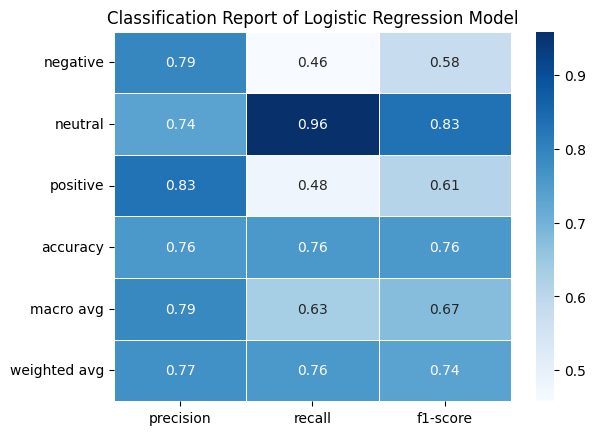

In [20]:
# Generate classification report with heatmap for Logistic Regression Model
report = classification_report(y_test, LR_model_predictions, output_dict=True)
# Convert report to DataFrame
df_report = pd.DataFrame(report).transpose()
# Drop the last row (support) as it's not needed for the plot
df_report = df_report.drop('support', axis=1)
# Plot the heatmap
sns.heatmap(df_report, annot=True, cmap='Blues', fmt=".2f", linewidths=.5)
plt.title('Classification Report of Logistic Regression Model')
plt.show()

# Record the F1 score of the Logistic Regression model from the classification report
f1_LR_model_report = df_report.loc['weighted avg', 'f1-score']

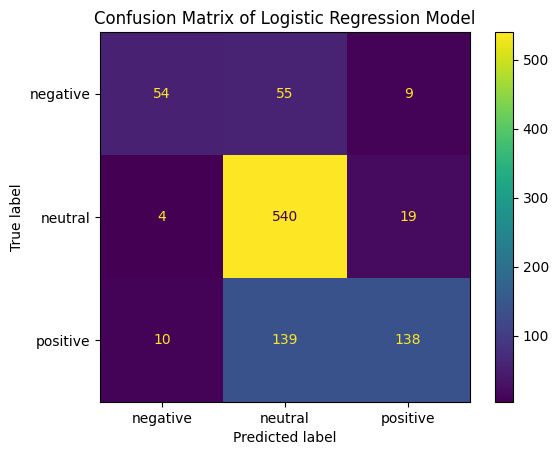

In [21]:
# Create confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, LR_model_predictions)
plt.title('Confusion Matrix of Logistic Regression Model')
plt.show()

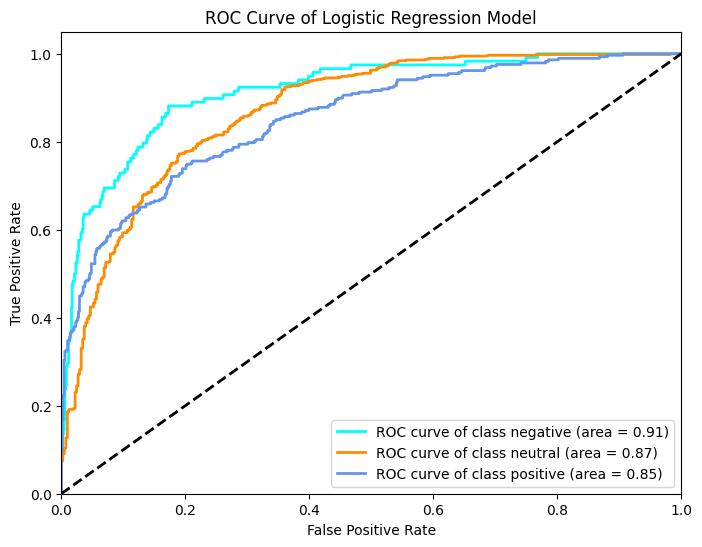

In [22]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, roc_auc_score
from itertools import cycle

# Convert the labels to a one-hot encoding
y_test_binarized = label_binarize(y_test, classes=np.unique(y_train))
n_classes = y_test_binarized.shape[1]

# Predict probabilities for each class
probs = LR_model.predict_proba(X_test_vectorized)

# Compute ROC curve and ROC area for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Define a mapping from class indices to names
class_names = {0: "negative", 1: "neutral", 2: "positive"}

# Plot all ROC curves with class names
plt.figure(figsize=(8, 6))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(class_names[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of Logistic Regression Model')
plt.legend(loc="lower right")
plt.show()

# Record the ROC AUC score of the Logistic Regression model
roc_auc_LR_model = roc_auc_score(y_test_binarized, probs, average='weighted', multi_class='ovr')

## Decision Tree Classification model

In [23]:
DT_model = DecisionTreeClassifier()
DT_model.fit(X_train_vectorized, y_train)

DecisionTreeClassifier()

In [24]:
DT_model_predictions = DT_model.predict(X_test_vectorized)

In [25]:
# Decision Tree model accuracy
DT_model_score = DT_model.score(X_test_vectorized, y_test)
# print Decision Tree model accuracy in percentage 2 decimal places
DT_model_score = round(DT_model_score*100, 2)
print(f'Decision Tree model accuracy: {DT_model_score}%')

Decision Tree model accuracy: 69.32%


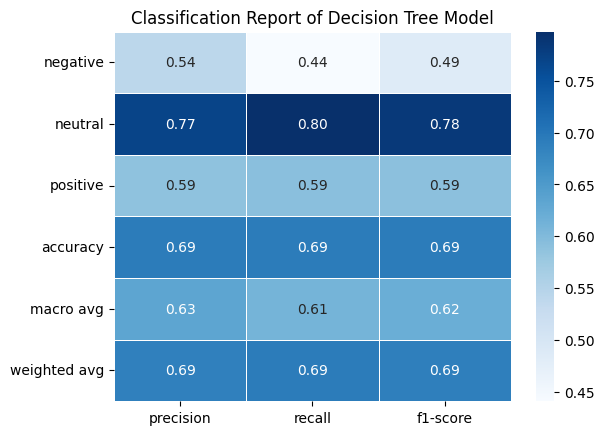

In [26]:
# Generate classification report with heatmap for Decision Tree model
report = classification_report(y_test, DT_model_predictions, output_dict=True)
# Convert report to DataFrame
df_report = pd.DataFrame(report).transpose()
# Drop the last row (support) as it's not needed for the plot
df_report = df_report.drop('support', axis=1)
# Plot the heatmap
sns.heatmap(df_report, annot=True, cmap='Blues', fmt=".2f", linewidths=.5)
plt.title('Classification Report of Decision Tree Model')
plt.show()

# Record the F1 score of the Decision Tree model from the classification report
f1_DT_model_report = df_report.loc['weighted avg', 'f1-score']

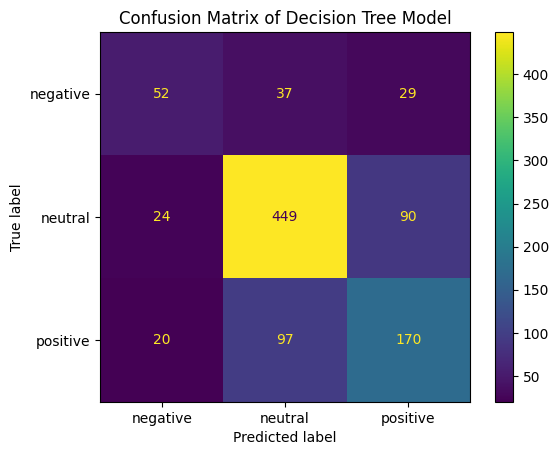

In [27]:
# Create confusion matrix for Decision Tree model
ConfusionMatrixDisplay.from_predictions(y_test, DT_model_predictions)
plt.title('Confusion Matrix of Decision Tree Model')
plt.show()

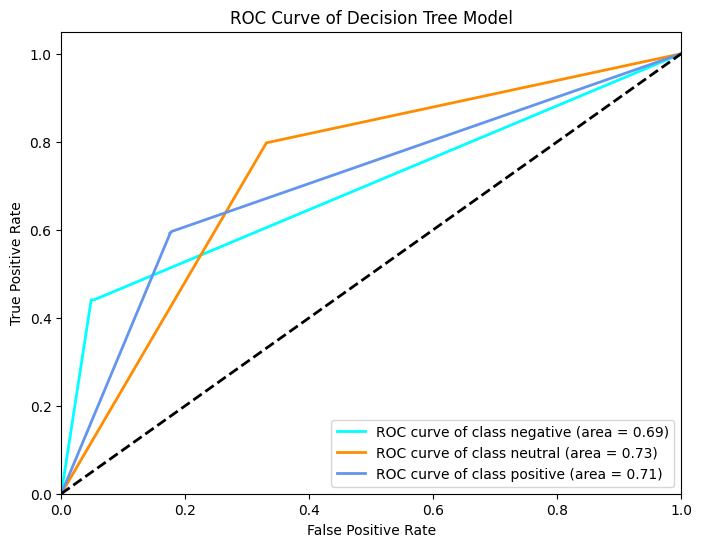

In [28]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, roc_auc_score
from itertools import cycle

# Convert the labels to a one-hot encoding
y_test_binarized = label_binarize(y_test, classes=np.unique(y_train))
n_classes = y_test_binarized.shape[1]

# Predict probabilities for each class
probs = DT_model.predict_proba(X_test_vectorized)

# Compute ROC curve and ROC area for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Define a mapping from class indices to names
class_names = {0: "negative", 1: "neutral", 2: "positive"}

# Plot all ROC curves with class names
plt.figure(figsize=(8, 6))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(class_names[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of Decision Tree Model')
plt.legend(loc="lower right")
plt.show()

# Record the ROC AUC score of the Decision Tree model
roc_auc_DT_model = roc_auc_score(y_test_binarized, probs, average='weighted', multi_class='ovr')

## Random Forest classification model

In [29]:
# Random Forest model
RF_model = RandomForestClassifier(random_state=0)
RF_model.fit(X_train_vectorized, y_train)

RandomForestClassifier(random_state=0)

In [30]:
# Random Forest model predictions
RF_model_predictions = RF_model.predict(X_test_vectorized)

In [31]:
# Random Forest model accuracy
RF_model_score = RF_model.score(X_test_vectorized, y_test)
# print Random Forest model accuracy in percentage 2 decimal places
RF_model_score = round(RF_model_score*100, 2)
print(f'Random Forest model accuracy: {RF_model_score}%')

Random Forest model accuracy: 74.28%


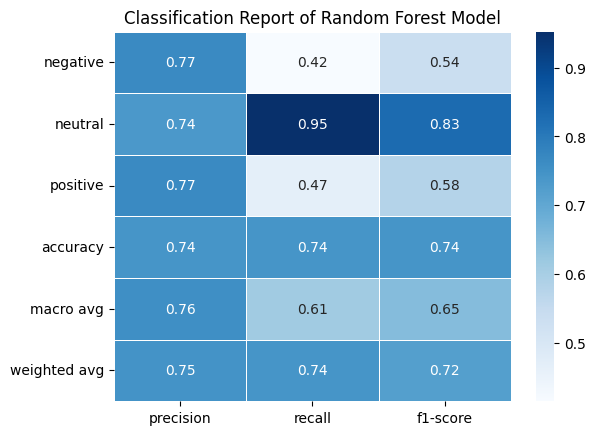

In [32]:
# Generate classification report with heatmap for Random Forest model
report = classification_report(y_test, RF_model_predictions, output_dict=True)
# Convert report to DataFrame
df_report = pd.DataFrame(report).transpose()
# Drop the last row (support) as it's not needed for the plot
df_report = df_report.drop('support', axis=1)
# Plot the heatmap
sns.heatmap(df_report, annot=True, cmap='Blues', fmt=".2f", linewidths=.5)
plt.title('Classification Report of Random Forest Model')
plt.show()

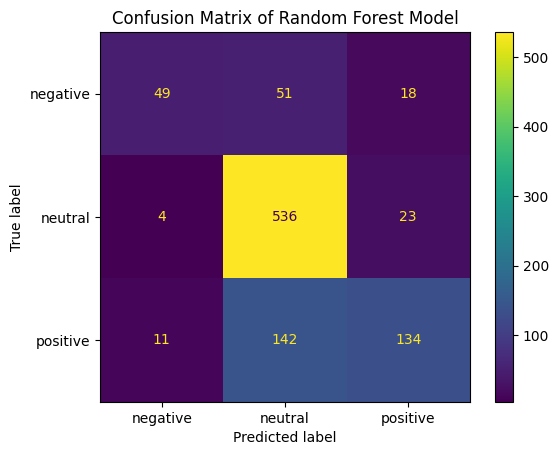

In [33]:
# Create confusion matrix for Random Forest model
ConfusionMatrixDisplay.from_predictions(y_test, RF_model_predictions)
plt.title('Confusion Matrix of Random Forest Model')
plt.show()

## Support Vector Machine Model

In [34]:
# Support Vector Machine model
from sklearn.svm import SVC
SVM_model = SVC()
SVM_model.fit(X_train_vectorized, y_train)

# Support Vector Machine model predictions
SVM_model_predictions = SVM_model.predict(X_test_vectorized)

# Support Vector Machine model accuracy
SVM_model_score = SVM_model.score(X_test_vectorized, y_test)
# print Support Vector Machine model accuracy in percentage 2 decimal places
SVM_model_score = round(SVM_model_score*100, 2)
print(f'Support Vector Machine model accuracy: {SVM_model_score}%')

Support Vector Machine model accuracy: 73.14%


## Generate classification report with heatmap for Support Vector Machine model

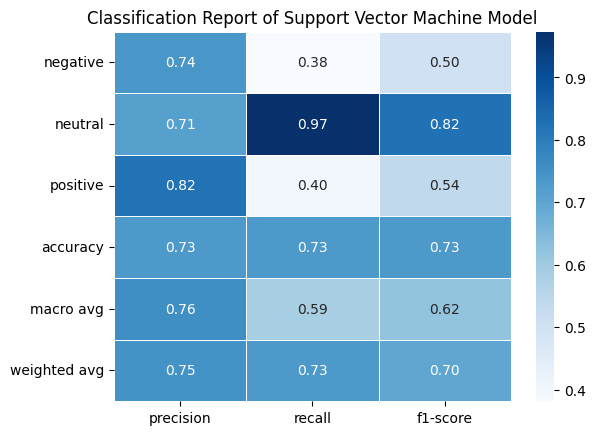

In [35]:
# Generate classification report with heatmap for Support Vector Machine model
report = classification_report(y_test, SVM_model_predictions, output_dict=True)
# Convert report to DataFrame
df_report = pd.DataFrame(report).transpose()
# Drop the last row (support) as it's not needed for the plot
df_report = df_report.drop('support', axis=1)
# Plot the heatmap
sns.heatmap(df_report, annot=True, cmap='Blues', fmt=".2f", linewidths=.5)
plt.title('Classification Report of Support Vector Machine Model')
plt.show()

## Create confusion matrix for Support Vector Machine model

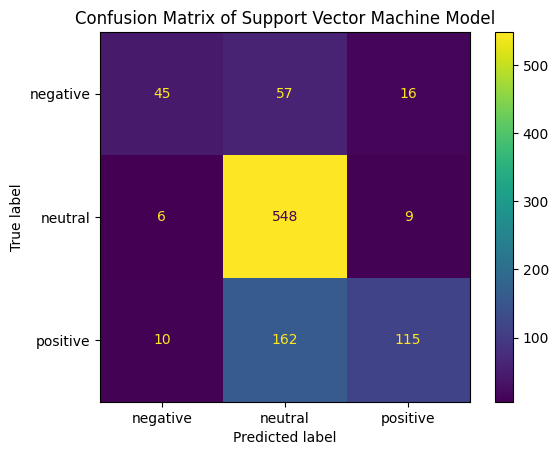

In [36]:
# Create confusion matrix for Support Vector Machine model
ConfusionMatrixDisplay.from_predictions(y_test, SVM_model_predictions)
plt.title('Confusion Matrix of Support Vector Machine Model')
plt.show()

## Feedforward Neural Network Model

NeuralNetwork(
  (fc1): Linear(in_features=6337, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=3, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
Epoch 1/200, Loss: 1.0439988566983132, Accuracy: 57.72210743801653
Epoch 2/200, Loss: 0.8905665912935811, Accuracy: 59.65909090909091
Epoch 3/200, Loss: 0.7792511543919963, Accuracy: 61.36363636363637
Epoch 4/200, Loss: 0.6483197894788557, Accuracy: 68.87913223140495
Epoch 5/200, Loss: 0.5074999111313974, Accuracy: 77.24690082644628
Epoch 6/200, Loss: 0.3883041085735444, Accuracy: 83.29028925619835
Epoch 7/200, Loss: 0.29057494334636197, Accuracy: 90.0051652892562
Epoch 8/200, Loss: 0.2213102091223963, Accuracy: 92.53615702479338
Epoch 9/200, Loss: 0.17313805294613685, Accuracy: 94.75723140495867
Epoch 10/200, Loss: 0.1514082007831143, Accuracy: 95.48037190082644
Epoch 11/200, Loss: 0.12623803053171403, Accuracy: 96.2551652892562
Epoch 12/200, Los

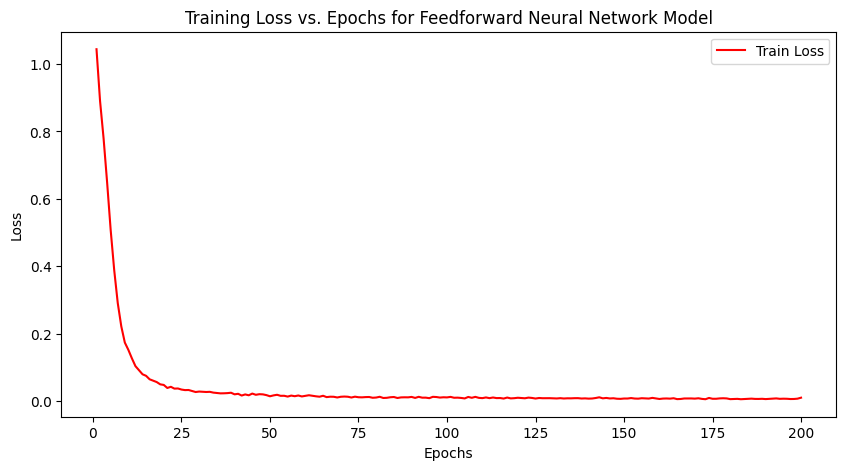

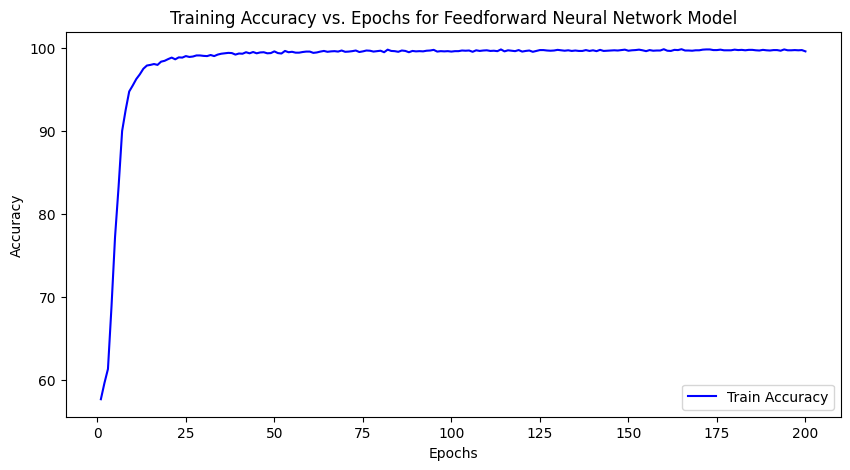

 Feedforward Neural Network model accuracy: 72.62%


In [37]:
# Neural Network model with pytorch without mixup
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, roc_curve, auc
from scipy import interp
from itertools import cycle
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Encode the target variables to numeric format
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Convert the data to tensors
X_train_tensor = torch.tensor(X_train_vectorized.toarray(), dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test_vectorized.toarray(), dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_encoded, dtype=torch.int64).to(device)
y_test_tensor = torch.tensor(y_test_encoded, dtype=torch.int64).to(device)

# Create a DataLoader
train_data = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)

# Neural Network model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(X_train_vectorized.shape[1], 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 3)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

model = NeuralNetwork()
model.to(device) # Move the model to the GPU if available
print(model)

# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Before the training loop, initialize lists to track metrics
train_losses = []
train_accuracies = []

# Train the model
epochs = 200
for epoch in range(epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:

        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # For accuracy calculation
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_losses.append(running_loss/len(train_loader))
    train_accuracies.append(100 * correct / total)
    print(f'Epoch {epoch+1}/{epochs}, Loss: {train_losses[-1]}, Accuracy: {train_accuracies[-1]}')

# Plot the training loss over epochs
plt.figure(figsize=(10,5))
plt.plot(range(1, epochs+1), train_losses, label='Train Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss vs. Epochs for Feedforward Neural Network Model')
plt.show()

# Plot the training accuracy over epochs
plt.figure(figsize=(10,5))
plt.plot(range(1, epochs+1), train_accuracies, label='Train Accuracy', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training Accuracy vs. Epochs for Feedforward Neural Network Model')
plt.show()

# Neural Network model predictions
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, NN_model_predictions = torch.max(outputs, 1)

# Neural Network model accuracy
NN_model_score = accuracy_score(y_test_encoded, NN_model_predictions.cpu().numpy())

# print Neural Network model accuracy in percentage 2 decimal places
NN_model_score = round(NN_model_score*100, 2)
print(f' Feedforward Neural Network model accuracy: {NN_model_score}%')

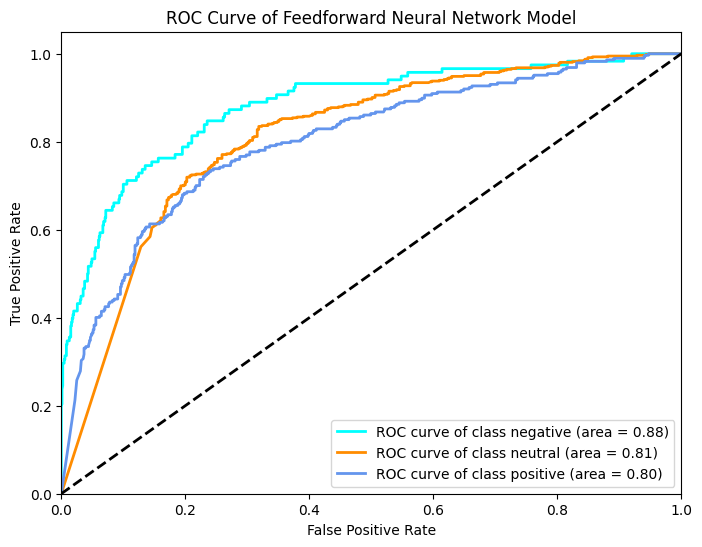

In [38]:
# Preparing for ROC Curve and AUC
# Convert the labels to a one-hot encoding
y_test_binarized = label_binarize(y_test_encoded, classes=np.unique(y_train_encoded))
n_classes = y_test_binarized.shape[1]

# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move the model to the device
model = model.to(device)

# Move the test tensor to the device
X_test_tensor = X_test_tensor.to(device)

# Predict probabilities for each class with GPU
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    outputs = model(X_test_tensor)
    probs = torch.softmax(outputs, dim=1).cpu().numpy()


# Compute ROC curve and ROC area for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Define a mapping from class indices to names
class_names = {0: "negative", 1: "neutral", 2: "positive"}

# Plot all ROC curves with class names
plt.figure(figsize=(8, 6))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(class_names[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of Feedforward Neural Network Model')
plt.legend(loc="lower right")
plt.show()

# Record the ROC AUC score of the Neural Network model
roc_auc_NN_model = roc_auc_score(y_test_binarized, probs, average='weighted', multi_class='ovr')

## classification report with heatmap for Neural Network model with encoded labels

In [39]:
# # Generate classification report with heatmap for Neural Network model with encoded labels
# report = classification_report(y_test_encoded, NN_model_predictions.numpy(), output_dict=True)
# # Convert report to DataFrame
# df_report = pd.DataFrame(report).transpose()
# # Drop the last row (support) as it's not needed for the plot
# df_report = df_report.drop('support', axis=1)
# # Plot the heatmap
# sns.heatmap(df_report, annot=True, cmap='Blues', fmt=".2f", linewidths=.5)
# plt.title('Classification Report of Neural Network Model (encoded labels)')
# plt.show()

## confusion matrix for Neural Network model with encoded labels

In [40]:
# # Create confusion matrix for Neural Network model with encoded labels
# ConfusionMatrixDisplay.from_predictions(y_test_encoded, NN_model_predictions.numpy())
# plt.title('Confusion Matrix of Neural Network Model (encoded labels)')
# plt.show()

## Decode predictions back to original labels

In [41]:
# Decode predictions back to original labels for classification report of Neural Network model
decoded_predictions = label_encoder.inverse_transform(NN_model_predictions.cpu().numpy())
decoded_y_test = label_encoder.inverse_transform(y_test_encoded)

## classification report with heatmap for Neural Network model with decoded labels

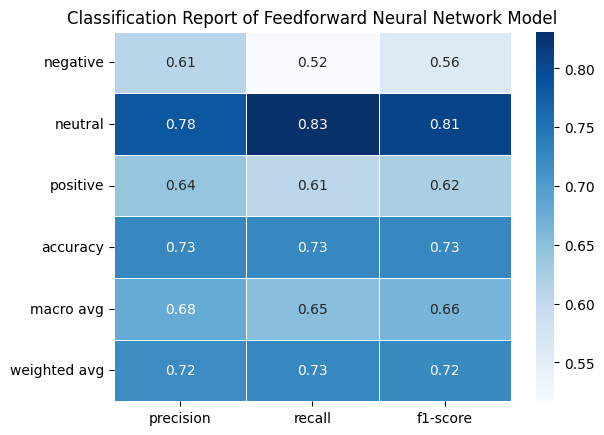

In [42]:
# Generate classification report with heatmap for Neural Network model with decoded labels
report = classification_report(decoded_y_test, decoded_predictions, output_dict=True)
# Convert report to DataFrame
df_report = pd.DataFrame(report).transpose()
# Drop the last row (support) as it's not needed for the plot
df_report = df_report.drop('support', axis=1)
# Plot the heatmap
sns.heatmap(df_report, annot=True, cmap='Blues', fmt=".2f", linewidths=.5)
plt.title('Classification Report of Feedforward Neural Network Model')
plt.show()

# Record the F1 score of the Neural Network model from the classification report
f1_NN_model_report = df_report.loc['weighted avg', 'f1-score']

## confusion matrix for Neural Network model with decoded labels

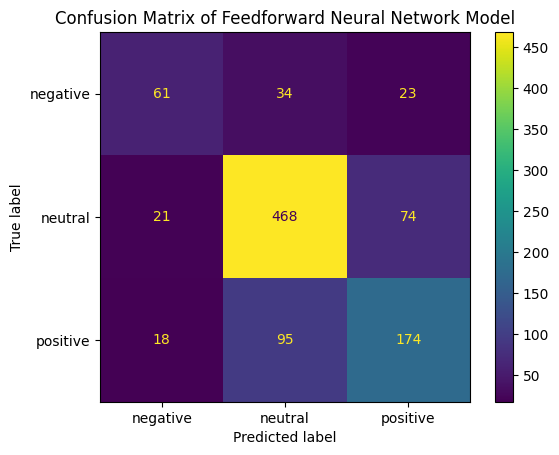

In [43]:
# Create confusion matrix for Neural Network model with decoded labels
ConfusionMatrixDisplay.from_predictions(decoded_y_test, decoded_predictions)
plt.title('Confusion Matrix of Feedforward Neural Network Model')
plt.show()

## Convolutional Neural Network Model

TextCNN(
  (embedding): Embedding(6356, 128)
  (conv1): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
  (conv2): Conv1d(128, 64, kernel_size=(3,), stride=(1,))
  (fc): Linear(in_features=1920, out_features=3, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
Epoch 1/200, Loss: 0.9334528580788644, Accuracy: 59.16838842975206
Epoch 2/200, Loss: 0.8478868776752103, Accuracy: 62.03512396694215
Epoch 3/200, Loss: 0.7489765747900932, Accuracy: 66.94214876033058
Epoch 4/200, Loss: 0.6192350714437423, Accuracy: 73.78615702479338
Epoch 5/200, Loss: 0.4862699229871073, Accuracy: 80.99173553719008
Epoch 6/200, Loss: 0.3510721710420424, Accuracy: 86.67355371900827
Epoch 7/200, Loss: 0.2528625399835648, Accuracy: 91.2448347107438
Epoch 8/200, Loss: 0.18275230498083175, Accuracy: 93.95661157024793
Epoch 9/200, Loss: 0.13681427677792887, Accuracy: 96.15185950413223
Epoch 10/200, Loss: 0.10352483932529727, Accuracy: 97.4948347107438
Epoch 11/200, Loss: 0.08014846220612526, Accuracy: 97.7789256

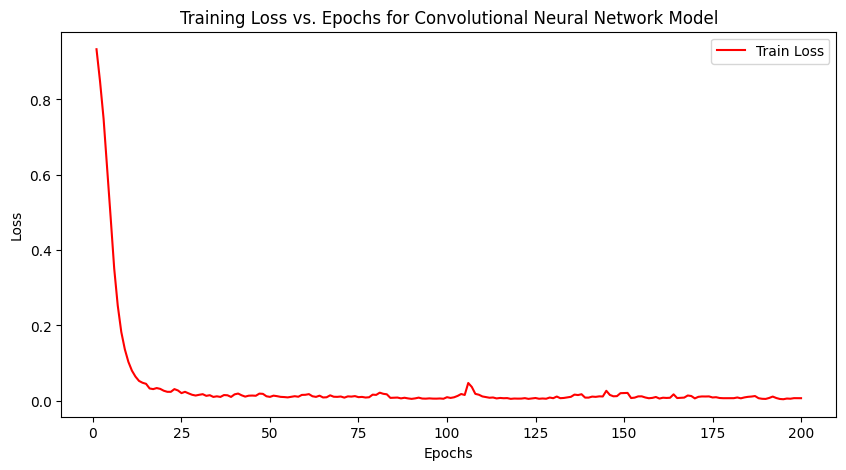

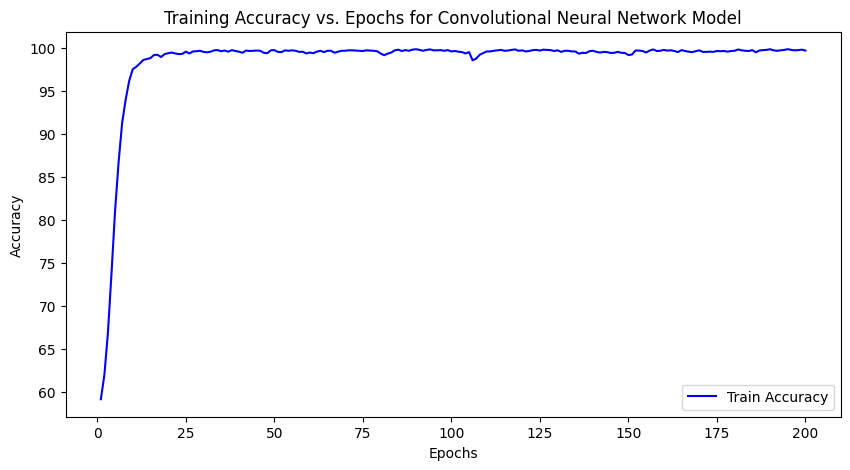

Convolutional Neural Network model accuracy: 69.52%


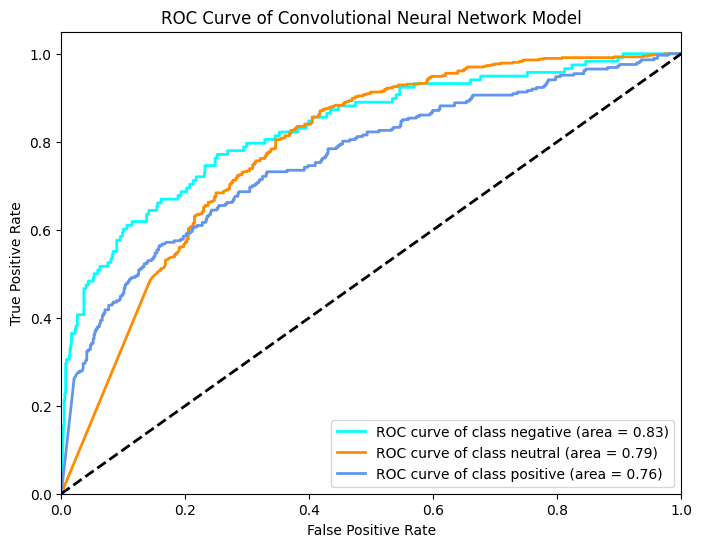

In [44]:
# Implement Convolutional Neural Network (CNN) model with PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

from torch.utils.data import DataLoader, TensorDataset, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np
import pandas as pd

# Encode the target variables/labels to numeric format after the data split
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Tokenize the text data to get sequences for the CNN model after the data split
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

# Pad the sequences to ensure uniform length/input size for the CNN model
max_length = max(max(len(x) for x in X_train_sequences), max(len(x) for x in X_test_sequences))
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_length, padding='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_length, padding='post')

vocab_size = len(tokenizer.word_index) + 1 # Add 1 for the 0 padding

# Create a Pytorch Dataset
class TextDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.long), torch.tensor(self.y[idx], dtype=torch.float32)



# Create a DataLoader
train_data = TextDataset(X_train_padded, y_train_encoded)
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)

# Define the Convolutional Neural Network (CNN) model
class TextCNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_classes):
        super(TextCNN, self).__init__()
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embed_dim)
        self.conv1 = nn.Conv1d(in_channels=embed_dim, out_channels=128, kernel_size=3)
        self.conv2 = nn.Conv1d(in_channels=128, out_channels=64, kernel_size=3)
        self.fc = nn.Linear(64 * (max_length - 2 * 3 + 2), num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.embedding(x).permute(0, 2, 1)
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

# Set the device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Instantiate the CNN model
model = TextCNN(vocab_size, 128, 3)
model.to(device)

print(model)

# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


# Before the training loop, initialize lists to track metrics
train_losses = []
train_accuracies = []

# Train the model
epochs = 200
for epoch in range(epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    for texts, labels in train_loader:
        texts, labels = texts.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(texts)
        loss = criterion(outputs, labels.long())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # For accuracy calculation
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_losses.append(running_loss/len(train_loader))
    train_accuracies.append(100 * correct / total)
    print(f'Epoch {epoch+1}/{epochs}, Loss: {train_losses[-1]}, Accuracy: {train_accuracies[-1]}')

# Plot the training loss over epochs
plt.figure(figsize=(10,5))
plt.plot(range(1, epochs+1), train_losses, label='Train Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss vs. Epochs for Convolutional Neural Network Model')
plt.show()

# Plot the training accuracy over epochs
plt.figure(figsize=(10,5))
plt.plot(range(1, epochs+1), train_accuracies, label='Train Accuracy', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training Accuracy vs. Epochs for Convolutional Neural Network Model')
plt.show()

# CNN model predictions
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    outputs = model(torch.tensor(X_test_padded, dtype=torch.long).to(device))
    _, CNN_model_predictions = torch.max(outputs, 1)

# CNN model accuracy
CNN_model_score = accuracy_score(y_test_encoded, CNN_model_predictions.cpu().numpy())

# print CNN model accuracy in percentage 2 decimal places
CNN_model_score = round(CNN_model_score*100, 2)
print(f'Convolutional Neural Network model accuracy: {CNN_model_score}%')



# Preparing for ROC Curve and AUC for CNN model
# Convert the labels to a one-hot encoding
y_test_binarized = label_binarize(y_test_encoded, classes=np.unique(y_train_encoded))
n_classes = y_test_binarized.shape[1]

# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move the model to the device
model = model.to(device)

# Predict probabilities for each class with GPU
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    outputs = model(torch.tensor(X_test_padded, dtype=torch.long).to(device))
    probs = torch.softmax(outputs, dim=1).cpu().numpy()


# Compute ROC curve and ROC area for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Define a mapping from class indices to names
class_names = {0: "negative", 1: "neutral", 2: "positive"}

# Plot all ROC curves with class names
plt.figure(figsize=(8, 6))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(class_names[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of Convolutional Neural Network Model')
plt.legend(loc="lower right")
plt.show()

# Record the ROC AUC score of the CNN model
roc_auc_CNN_model = roc_auc_score(y_test_binarized, probs, average='weighted', multi_class='ovr')

## Generate classification report with heatmap for Convolutional Neural Network model with encoded labels

In [45]:
# # Generate classification report with heatmap for Convolutional Neural Network model
# report = classification_report(y_test_encoded, CNN_model_predictions.cpu().numpy(), output_dict=True)
# # Convert report to DataFrame
# df_report = pd.DataFrame(report).transpose()
# # Drop the last row (support) as it's not needed for the plot
# df_report = df_report.drop('support', axis=1)
# # Plot the heatmap
# sns.heatmap(df_report, annot=True, cmap='Blues', fmt=".2f", linewidths=.5)
# plt.title('Classification Report of Convolutional Neural Network Model')
# plt.show()

## Create confusion matrix for Convolutional Neural Network model with encoded labels

In [46]:
# # Create confusion matrix for Convolutional Neural Network model
# ConfusionMatrixDisplay.from_predictions(y_test_encoded, CNN_model_predictions.cpu().numpy())
# plt.title('Confusion Matrix of Convolutional Neural Network Model')
# plt.show()

## Decode predictions back to original labels for classification report of Convolutional Neural Network model

In [47]:
# Decode predictions back to original labels for classification report of Convolutional Neural Network model
decoded_predictions = label_encoder.inverse_transform(CNN_model_predictions.cpu().numpy())
decoded_y_test = label_encoder.inverse_transform(y_test_encoded)

## Generate classification report with heatmap for Convolutional Neural Network model with decoded labels

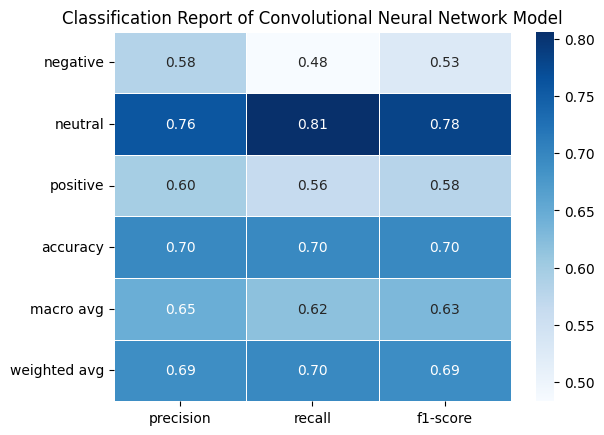

In [48]:
# Generate classification report with heatmap for Convolutional Neural Network model with decoded labels
report = classification_report(decoded_y_test, decoded_predictions, output_dict=True)
# Convert report to DataFrame
df_report = pd.DataFrame(report).transpose()
# Drop the last row (support) as it's not needed for the plot
df_report = df_report.drop('support', axis=1)
# Plot the heatmap
sns.heatmap(df_report, annot=True, cmap='Blues', fmt=".2f", linewidths=.5)
plt.title('Classification Report of Convolutional Neural Network Model')
plt.show()

# Record the F1 score of the Convolutional Neural Network model from the classification report
f1_CNN_model_report = df_report.loc['weighted avg', 'f1-score']

## Create confusion matrix for Convolutional Neural Network model with decoded labels

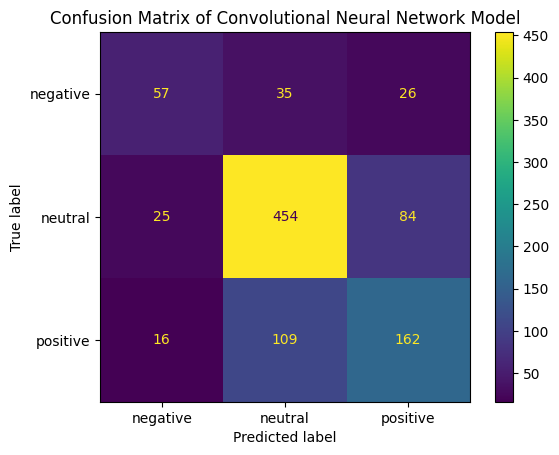

In [49]:
# Create confusion matrix for Convolutional Neural Network model with decoded labels
ConfusionMatrixDisplay.from_predictions(decoded_y_test, decoded_predictions)
plt.title('Confusion Matrix of Convolutional Neural Network Model')
plt.show()

## LSTM Model

LSTM(
  (embedding): Embedding(6356, 128)
  (lstm): LSTM(128, 64, num_layers=2, batch_first=True, dropout=0.4, bidirectional=True)
  (attention): SelfAttention(
    (projection): Sequential(
      (0): Linear(in_features=128, out_features=64, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=64, out_features=1, bias=True)
    )
  )
  (fc): Linear(in_features=128, out_features=3, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
)
Epoch 1/200, Loss: 0.9528367423242138, Accuracy: 58.49690082644628
Epoch 2/200, Loss: 0.9123449498607267, Accuracy: 59.736570247933884
Epoch 3/200, Loss: 0.844032549089001, Accuracy: 63.32644628099174
Epoch 4/200, Loss: 0.7893620056490744, Accuracy: 65.65082644628099
Epoch 5/200, Loss: 0.7302039803997162, Accuracy: 69.78305785123968
Epoch 6/200, Loss: 0.6679526240594925, Accuracy: 73.24380165289256
Epoch 7/200, Loss: 0.6181838108647254, Accuracy: 74.92252066115702
Epoch 8/200, Loss: 0.5684082296586805, Accuracy: 77.06611570247934
Epoch

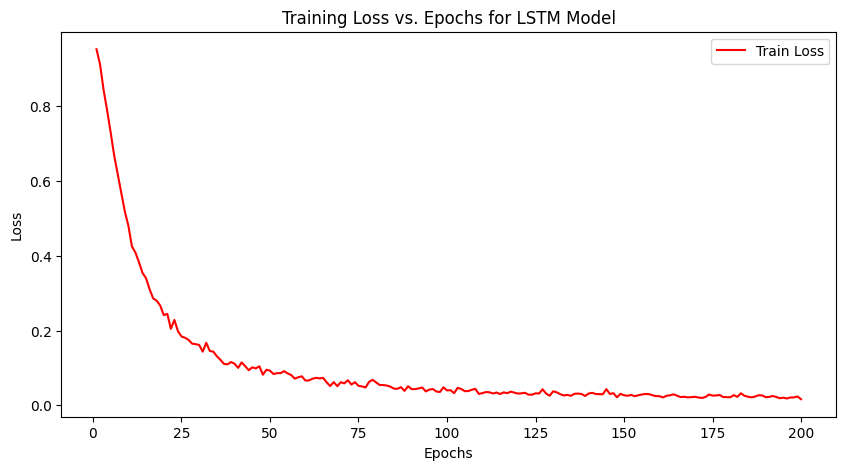

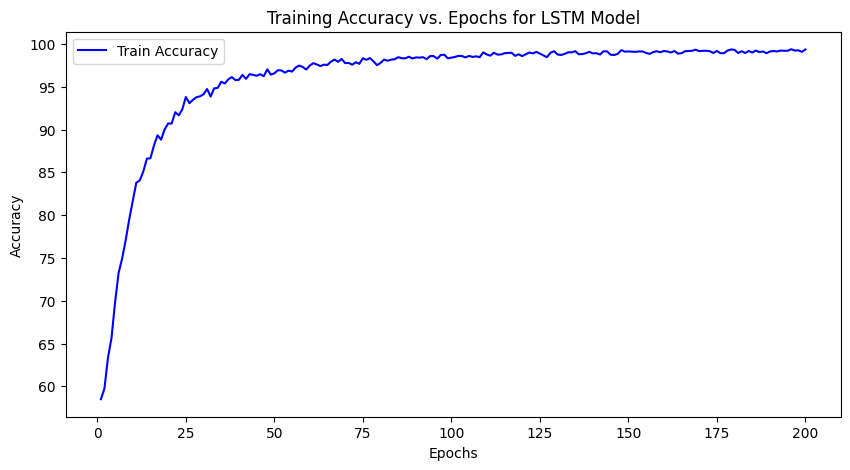

LSTM model accuracy: 73.76%


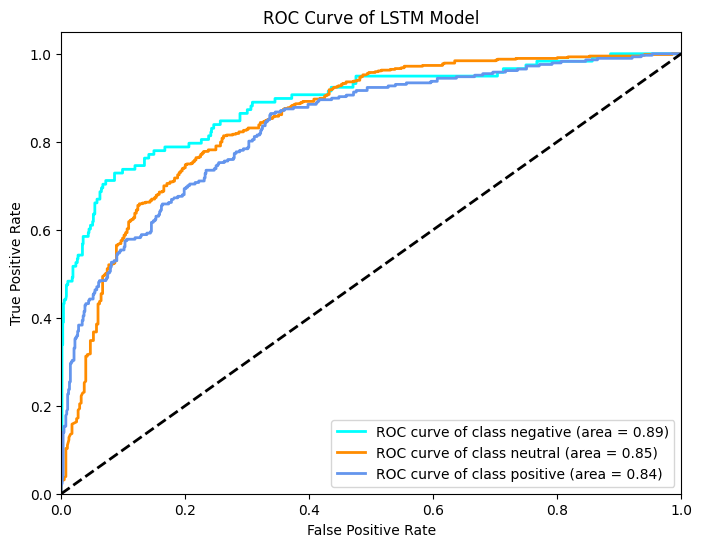

In [50]:
# LSTM model with PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import torch.nn.functional as F

from torch.utils.data import DataLoader, TensorDataset, Dataset
from sklearn.model_selection import train_test_split

# Encode the target variables/labels to numeric format after the data split for the LSTM model
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Tokenize the text data to get sequences for the LSTM model after the data split
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

# Pad the sequences to ensure uniform length/input size for the LSTM model
max_length = max(max(len(x) for x in X_train_sequences), max(len(x) for x in X_test_sequences))
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_length, padding='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_length, padding='post')

vocab_size = len(tokenizer.word_index) + 1 # Add 1 for the 0 padding

# Create a Pytorch Dataset
class TextDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.long), torch.tensor(self.y[idx], dtype=torch.float32)



# Create a DataLoader
train_data = TextDataset(X_train_padded, y_train_encoded)
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)

class SelfAttention(nn.Module):
    def __init__(self, hidden_dim):
        super(SelfAttention, self).__init__()
        self.projection = nn.Sequential(
            nn.Linear(hidden_dim, 64),
            nn.ReLU(True),
            nn.Linear(64, 1)
        )

    def forward(self, encoder_outputs):
        # encoder_outputs: (batch_size, seq_length, hidden_dim)
        energy = self.projection(encoder_outputs)  # (batch_size, seq_length, 1)
        weights = torch.nn.functional.softmax(energy.squeeze(-1), dim=1)  # (batch_size, seq_length)
        outputs = (encoder_outputs * weights.unsqueeze(-1)).sum(dim=1)  # (batch_size, hidden_dim)
        return outputs

# Define the LSTM model
class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout):
        super(LSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        # Adjusting for an additional LSTM layer
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers, bidirectional=bidirectional, dropout=dropout, batch_first=True)
        self.attention = SelfAttention(hidden_dim*2)  # Assuming bidirectional=True
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # Adjusted for attention mechanism
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        embedded = self.dropout(self.embedding(text))
        lstm_output, (hidden, cell) = self.lstm(embedded)
        # Attention layer
        attn_output = self.attention(lstm_output)
        out = self.fc(self.dropout(attn_output))
        return out




# Set the device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Instantiate the LSTM model
model = LSTM(vocab_size, 128, 64, 3, 2, True, 0.4)
model.to(device)

print(model)



# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)

# Before the training loop, initialize lists to track metrics
train_losses = []
train_accuracies = []

# Train the model
epochs = 200
for epoch in range(epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    for texts, labels in train_loader:
        texts, labels = texts.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(texts)
        loss = criterion(outputs, labels.long())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # For accuracy calculation
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_losses.append(running_loss/len(train_loader))
    train_accuracies.append(100 * correct / total)
    print(f'Epoch {epoch+1}/{epochs}, Loss: {train_losses[-1]}, Accuracy: {train_accuracies[-1]}')

# Plot the training loss over epochs
plt.figure(figsize=(10,5))
plt.plot(range(1, epochs+1), train_losses, label='Train Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss vs. Epochs for LSTM Model')
plt.show()

# Plot the training accuracy over epochs
plt.figure(figsize=(10,5))
plt.plot(range(1, epochs+1), train_accuracies, label='Train Accuracy', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training Accuracy vs. Epochs for LSTM Model')
plt.show()

# LSTM model predictions
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    outputs = model(torch.tensor(X_test_padded, dtype=torch.long).to(device))
    _, LSTM_model_predictions = torch.max(outputs, 1)

# LSTM model accuracy
LSTM_model_score = accuracy_score(y_test_encoded, LSTM_model_predictions.cpu().numpy())

# print LSTM model accuracy in percentage 2 decimal places
LSTM_model_score = round(LSTM_model_score*100, 2)
print(f'LSTM model accuracy: {LSTM_model_score}%')


# Preparing for ROC Curve and AUC for LSTM model
# Convert the labels to a one-hot encoding
y_test_binarized = label_binarize(y_test_encoded, classes=np.unique(y_train_encoded))
n_classes = y_test_binarized.shape[1]

# Predict probabilities
probs = nn.functional.softmax(model(torch.tensor(X_test_padded, dtype=torch.long).to(device)), dim=1).cpu().detach().numpy()

# Compute ROC curve and ROC area for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Define a mapping from class indices to names
class_names = {0: "negative", 1: "neutral", 2: "positive"}

# Plot all ROC curves with class names
plt.figure(figsize=(8, 6))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(class_names[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of LSTM Model')
plt.legend(loc="lower right")
plt.show()

# Record the ROC AUC score of the LSTM model
roc_auc_LSTM_model = roc_auc_score(y_test_binarized, probs, average='weighted', multi_class='ovr')

## Decode predictions back to original labels for classification report of LSTM model

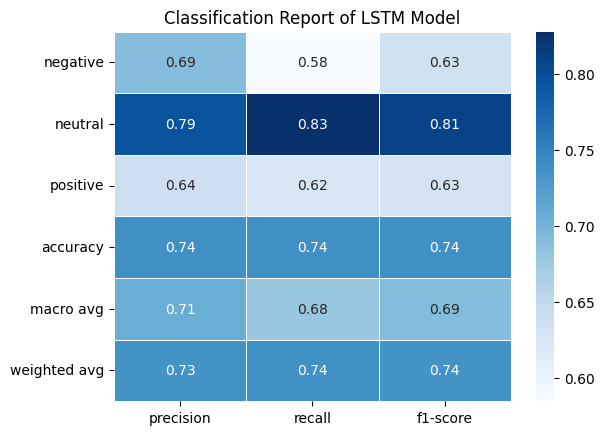

In [51]:
# Decode predictions back to original labels for classification report of LSTM model
decoded_predictions = label_encoder.inverse_transform(LSTM_model_predictions.cpu().numpy())
decoded_y_test = label_encoder.inverse_transform(y_test_encoded)

# Generate classification report with heatmap for LSTM model with decoded labels
report = classification_report(decoded_y_test, decoded_predictions, output_dict=True)
# Convert report to DataFrame
df_report = pd.DataFrame(report).transpose()
# Drop the last row (support) as it's not needed for the plot
df_report = df_report.drop('support', axis=1)
# Plot the heatmap
sns.heatmap(df_report, annot=True, cmap='Blues', fmt=".2f", linewidths=.5)
plt.title('Classification Report of LSTM Model')
plt.show()

# Record the F1 score of the LSTM model from the classification report
f1_LSTM_model_report = df_report.loc['weighted avg', 'f1-score']

## Create confusion matrix for LSTM model with decoded labels

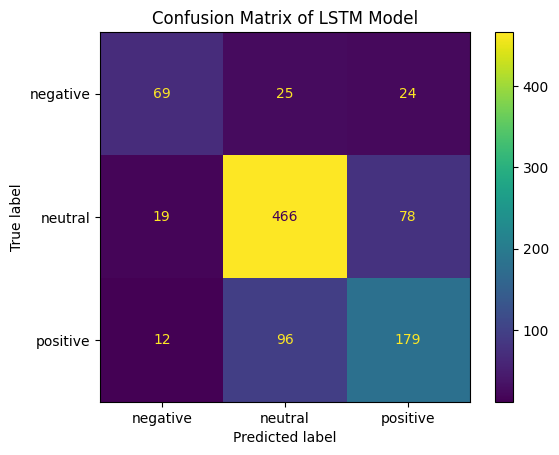

In [52]:
# Create confusion matrix for LSTM model with decoded labels
ConfusionMatrixDisplay.from_predictions(decoded_y_test, decoded_predictions)
plt.title('Confusion Matrix of LSTM Model')
plt.show()

## Financial Sentiment Analysis with BERT Transformer

In [ ]:
# Financial Sentiment Analysis with BERT model

# Preprocessing for BERT model
import pandas as pd
import numpy as np
import os
import random
from pathlib import Path
import json
import re
import string
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import torch.nn.functional as F
import torch
from tqdm.notebook import tqdm

from transformers import BertTokenizer
from torch.utils.data import TensorDataset

from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# Configure the BERT model
class Config():
    seed_val = 42
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    epochs = 10
    batch_size = 6
    seq_length = 256
    lr = 2e-5
    eps = 1e-8
    pretrained_model = 'bert-base-uncased'
    test_size=0.2
    random_state=42
    add_special_tokens=True
    return_attention_mask=True
    pad_to_max_length=True
    do_lower_case=False
    return_tensors='pt'

config = Config()

# params will be saved after training
params = {"seed_val": config.seed_val,
    "device":str(config.device),
    "epochs":config.epochs,
    "batch_size":config.batch_size,
    "seq_length":config.seq_length,
    "lr":config.lr,
    "eps":config.eps,
    "pretrained_model": config.pretrained_model,
    "test_size":config.test_size,
    "random_state":config.random_state,
    "add_special_tokens":config.add_special_tokens,
    "return_attention_mask":config.return_attention_mask,
    "pad_to_max_length":config.pad_to_max_length,
    "do_lower_case":config.do_lower_case,
    "return_tensors":config.return_tensors,
         }

# set random seed and device
import random

device = config.device
np.random.seed(config.seed_val)
np.random.seed(config.seed_val)
torch.manual_seed(config.seed_val)
torch.cuda.manual_seed_all(config.seed_val)

# Train Test Split
X = df['text']
y = df['Sentiment']

# Initialize the encoder
label_encoder = LabelEncoder()

# Fit and transform the labels to integer format
y_encoded = label_encoder.fit_transform(y)

# Now split the dataset again using the encoded labels
X_train, X_test, y_train_encoded, y_test_encoded = train_test_split(X, y_encoded, test_size=config.test_size, random_state=config.random_state)



# Bert Tokenizerand Encoding the Data
tokenizer = BertTokenizer.from_pretrained(config.pretrained_model, do_lower_case=config.do_lower_case)

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

for sent in X_train:
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = config.add_special_tokens, # Add '[CLS]' and '[SEP]'
                        max_length = config.seq_length,           # Pad & truncate all sentences.
                        pad_to_max_length = config.pad_to_max_length,
                        return_attention_mask = config.return_attention_mask,   # Construct attn. masks.
                        return_tensors = config.return_tensors,     # Return pytorch tensors.
                   )

    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(y_train_encoded)

# Combine the training inputs into a TensorDataset.
train_dataset = TensorDataset(input_ids, attention_masks, labels)

# Repeat the same process for test set
input_ids = []
attention_masks = []

for sent in X_test:
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = config.add_special_tokens, # Add '[CLS]' and '[SEP]'
                        max_length = config.seq_length,           # Pad & truncate all sentences.
                        pad_to_max_length = config.pad_to_max_length,
                        return_attention_mask = config.return_attention_mask,   # Construct attn. masks.
                        return_tensors = config.return_tensors,     # Return pytorch tensors.
                   )

    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(y_test_encoded)

# Combine the training inputs into a TensorDataset.
test_dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a DataLoader
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = config.batch_size # Trains with this batch size.
        )

# For test the order doesn't matter, so we'll just read them sequentially.
test_dataloader = DataLoader(
            test_dataset, # The validation samples.
            sampler = SequentialSampler(test_dataset), # Pull out batches sequentially.
            batch_size = config.batch_size # Evaluate with this batch size.
        )

# Load the BERT model
model = BertForSequenceClassification.from_pretrained(
    config.pretrained_model, # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 3, # The number of output labels--3 for positive, negative, neutral.
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

model.to(device)
print(model)


# Optimizer and Learning Rate Scheduler
optimizer = AdamW(model.parameters(),
                  lr = config.lr, # args.learning_rate - default is 5e-5, my notebook had 2e-5
                  eps = config.eps # args.adam_epsilon  - default is 1e-8.
                )

from transformers import get_linear_schedule_with_warmup
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = len(train_dataloader) * config.epochs)

# Training Loop
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
#
#
# Set the seed value all over the place to make this reproducible.
# set random seed and device
import random

device = config.device
random.seed(config.seed_val)
np.random.seed(config.seed_val)
torch.manual_seed(config.seed_val)
torch.cuda.manual_seed_all(config.seed_val)

# Helper function to calculate accuracy
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# Store the average loss and accuracy after each epoch so we can plot them.
loss_values = []
accuracy_values = []

for epoch_i in range(0, config.epochs):
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, config.epochs))
    print('Training...')

    # Reset the total loss for this epoch.
    total_loss = 0
    total_accuracy = 0

    model.train()

    for step, batch in enumerate(train_dataloader):
        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()

        outputs = model(b_input_ids,
                    token_type_ids=None,
                    attention_mask=b_input_mask,
                    labels=b_labels)

        loss = outputs[0]
        total_loss += loss.item()

        logits = outputs[1]
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        total_accuracy += flat_accuracy(logits, label_ids)

        loss.backward()
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_loss / len(train_dataloader)
    avg_train_accuracy = total_accuracy / len(train_dataloader)

    loss_values.append(avg_train_loss)
    accuracy_values.append(avg_train_accuracy)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Average training accuracy: {0:.2f}".format(avg_train_accuracy))
    print("")

# Plot the training loss over epochs
plt.figure(figsize=(10,5))
plt.plot(range(1, config.epochs+1), loss_values, label='Train Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss vs. Epochs for BERT Model')
plt.show()

# Plot the training accuracy over epochs
plt.figure(figsize=(10,5))
plt.plot(range(1, config.epochs+1), accuracy_values, label='Train Accuracy', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training Accuracy vs. Epochs for BERT Model')
plt.show()

# Evaluate the BERT model
# Prediction on test set
print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

model.eval()

predictions , true_labels = [], []

for batch in test_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask)

    logits = outputs[0]
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    predictions.append(logits)
    true_labels.append(label_ids)

print('    DONE.')

# Flatten the predictions and true values
flat_predictions = np.concatenate(predictions, axis=0)
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = np.concatenate(true_labels, axis=0)

# BERT model accuracy
BERT_model_score = accuracy_score(flat_true_labels, flat_predictions)

# print BERT model accuracy in percentage 2 decimal places
BERT_model_score = round(BERT_model_score*100, 2)
print(f'BERT model accuracy: {BERT_model_score}%')






## Preparing for ROC Curve and AUC for BERT model

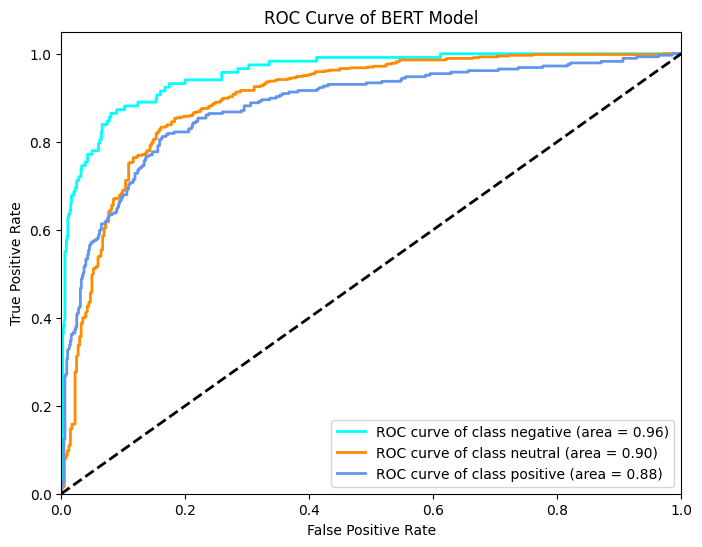

In [54]:
# Preparing for ROC Curve and AUC for BERT model
# Convert the labels to a one-hot encoding
y_test_binarized = label_binarize(flat_true_labels, classes=np.unique(y_train_encoded))
n_classes = y_test_binarized.shape[1]

# Predict probabilities
# probs = nn.functional.softmax(torch.tensor(flat_predictions), dim=1).cpu().detach().numpy()
# probs = nn.functional.softmax(torch.tensor(flat_predictions), dim=0).cpu().detach().numpy()

# Apply softmax to convert logits to probabilities
predictions_tensor = torch.tensor(np.vstack(predictions))  # Stacking along a new dimension

# Now apply softmax
probabilities = torch.softmax(predictions_tensor, dim=-1).numpy()

# Compute ROC curve and ROC area for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], probabilities[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Define a mapping from class indices to names
class_names = {0: "negative", 1: "neutral", 2: "positive"}

# Plot all ROC curves with class names
plt.figure(figsize=(8, 6))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(class_names[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of BERT Model')
plt.legend(loc="lower right")
plt.show()

# Record the ROC AUC score of the BERT model
roc_auc_BERT_model = roc_auc_score(y_test_binarized, probabilities, average='weighted', multi_class='ovr')

## Decode predictions back to original labels for classification report of BERT model

In [55]:
# Decode predictions back to original labels for classification report of BERT model
decoded_predictions = label_encoder.inverse_transform(flat_predictions)
decoded_y_test = label_encoder.inverse_transform(flat_true_labels)

## Generate classification report with heatmap for BERT model

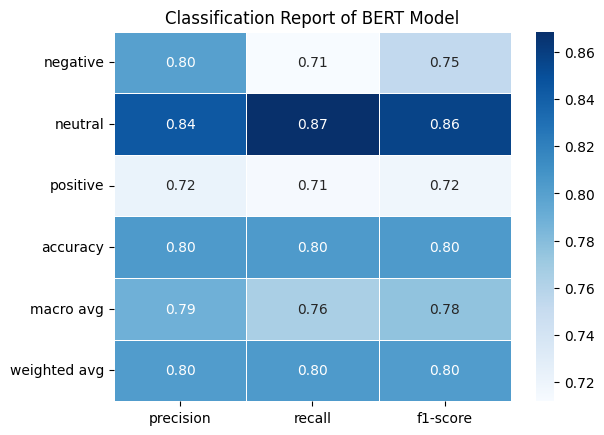

In [56]:
# # Generate classification report with heatmap for BERT model
# report = classification_report(flat_true_labels, flat_predictions, output_dict=True)
# # Convert report to DataFrame
# df_report = pd.DataFrame(report).transpose()
# # Drop the last row (support) as it's not needed for the plot
# df_report = df_report.drop('support', axis=1)
# # Plot the heatmap
# sns.heatmap(df_report, annot=True, cmap='Blues', fmt=".2f", linewidths=.5)
# plt.title('Classification Report of BERT Model')
# plt.show()


# Generate classification report with heatmap for BERT model with decoded labels
report = classification_report(decoded_y_test, decoded_predictions, output_dict=True)
# Convert report to DataFrame
df_report = pd.DataFrame(report).transpose()
# Drop the last row (support) as it's not needed for the plot
df_report = df_report.drop('support', axis=1)
# Plot the heatmap
sns.heatmap(df_report, annot=True, cmap='Blues', fmt=".2f", linewidths=.5)
plt.title('Classification Report of BERT Model')
plt.show()

# Record the F1 score of the BERT model from the classification report
f1_BERT_model_report = df_report.loc['weighted avg', 'f1-score']

## Create confusion matrix for BERT model

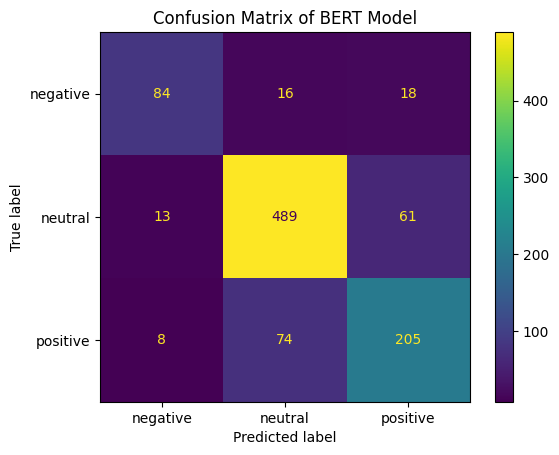

In [57]:
# # Create confusion matrix for BERT model
# ConfusionMatrixDisplay.from_predictions(flat_true_labels, flat_predictions)
# plt.title('Confusion Matrix of BERT Model')
# plt.show()


# Create confusion matrix for BERT model with decoded labels
ConfusionMatrixDisplay.from_predictions(decoded_y_test, decoded_predictions)
plt.title('Confusion Matrix of BERT Model')
plt.show()

# Compare the accuracy of models

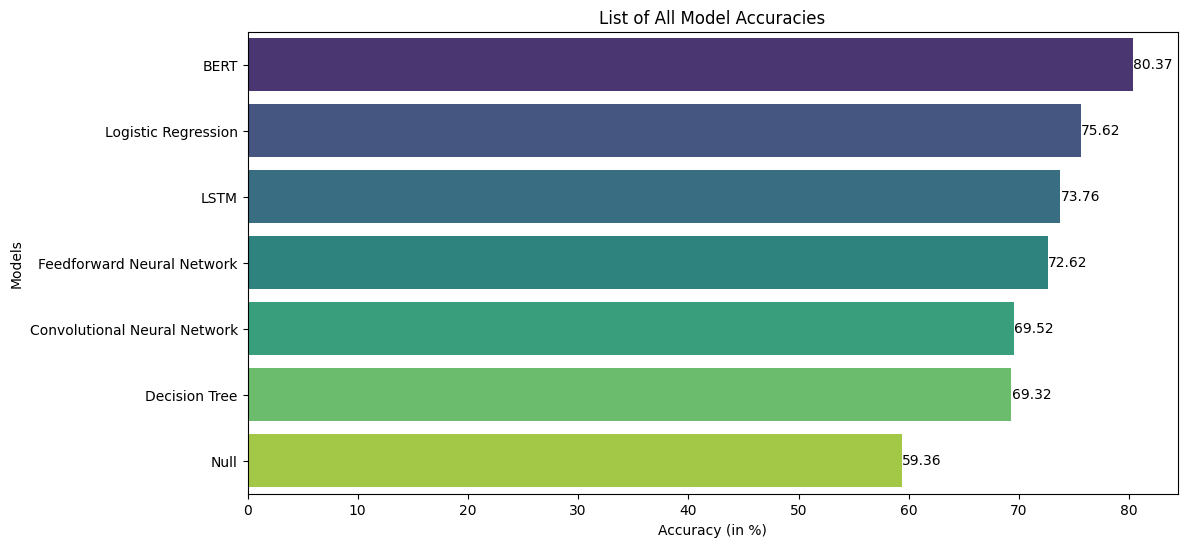

In [58]:
# Create a DataFrame to store the model results
model_results = pd.DataFrame({
    'Model': ['Null','Logistic Regression', 'Decision Tree', 'Feedforward Neural Network', 'Convolutional Neural Network', 'LSTM', 'BERT'],
    'Accuracy': [score_null_model, LR_model_score, DT_model_score, NN_model_score, CNN_model_score, LSTM_model_score, BERT_model_score]
})

# Sort the model results by accuracy in descending order
model_results = model_results.sort_values(by='Accuracy', ascending=False)
model_results.reset_index(drop=True, inplace=True)
model_results

# Round the accuracy values to 2 decimal places
model_results['Accuracy'] = model_results['Accuracy'].apply(lambda x: round(x, 2))

# Plot the model results
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='Accuracy', y='Model', data=model_results, palette='viridis')
plt.title('List of All Model Accuracies')
plt.xlabel('Accuracy (in %)')
plt.ylabel('Models')

# Annotate each bar with the corresponding accuracy value
for p in ax.patches:
    width = p.get_width()  # Get the width of the bar (accuracy value)
    # Place text at the end of the bar
    plt.text(width + 0.01,  # x-coordinate for text
             p.get_y() + p.get_height() / 2,  # y-coordinate for text
             '{:1.2f}'.format(width),  # Text to display (accuracy value)
             ha='left',  # Horizontal alignment
             va='center')  # Vertical alignment

plt.show()




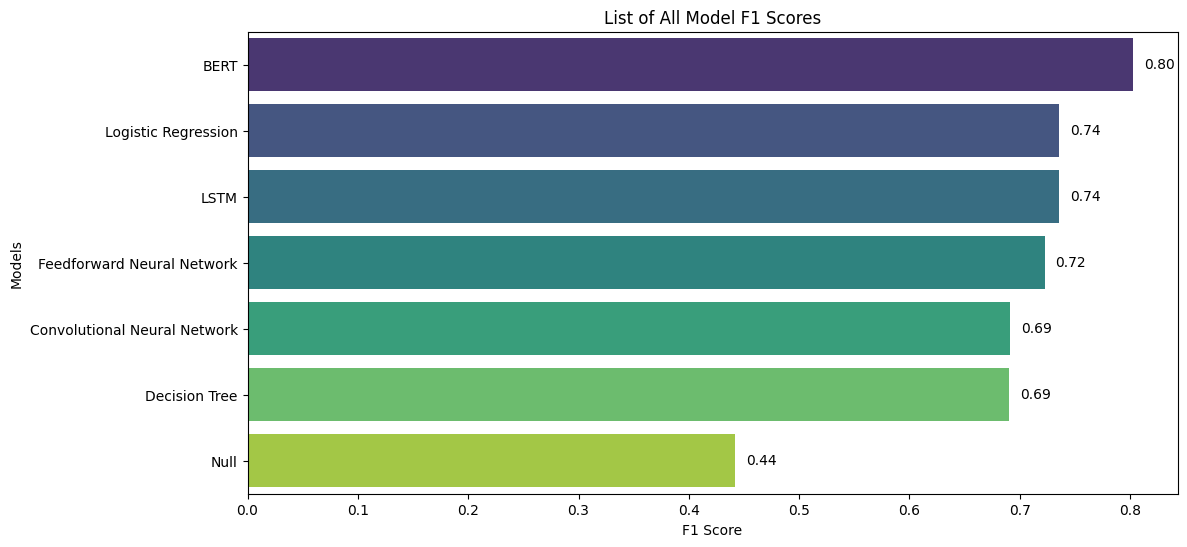

In [59]:
# Create a DataFrame to store the F1 scores of all models
f1_scores = pd.DataFrame({
    'Model': ['Feedforward Neural Network', 'Convolutional Neural Network', 'LSTM', 'BERT', 'Null', 'Logistic Regression', 'Decision Tree'],
    'F1 Score': [f1_NN_model_report, f1_CNN_model_report, f1_LSTM_model_report, f1_BERT_model_report, f1_null_model_report, f1_LR_model_report, f1_DT_model_report]
})

# Sort the F1 scores by descending order
f1_scores = f1_scores.sort_values(by='F1 Score', ascending=False)
f1_scores.reset_index(drop=True, inplace=True)
f1_scores

# Plot the F1 scores of all models
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='F1 Score', y='Model', data=f1_scores, palette='viridis')
plt.title('List of All Model F1 Scores')
plt.xlabel('F1 Score')
plt.ylabel('Models')

# Annotate each bar with the corresponding F1 score value
for p in ax.patches:
    width = p.get_width()  # Get the width of the bar (F1 score value)
    # Place text at the end of the bar
    plt.text(width + 0.01,  # x-coordinate for text
             p.get_y() + p.get_height() / 2,  # y-coordinate for text
             '{:1.2f}'.format(width),  # Text to display (F1 score value)
             ha='left',  # Horizontal alignment
             va='center')  # Vertical alignment

plt.show()

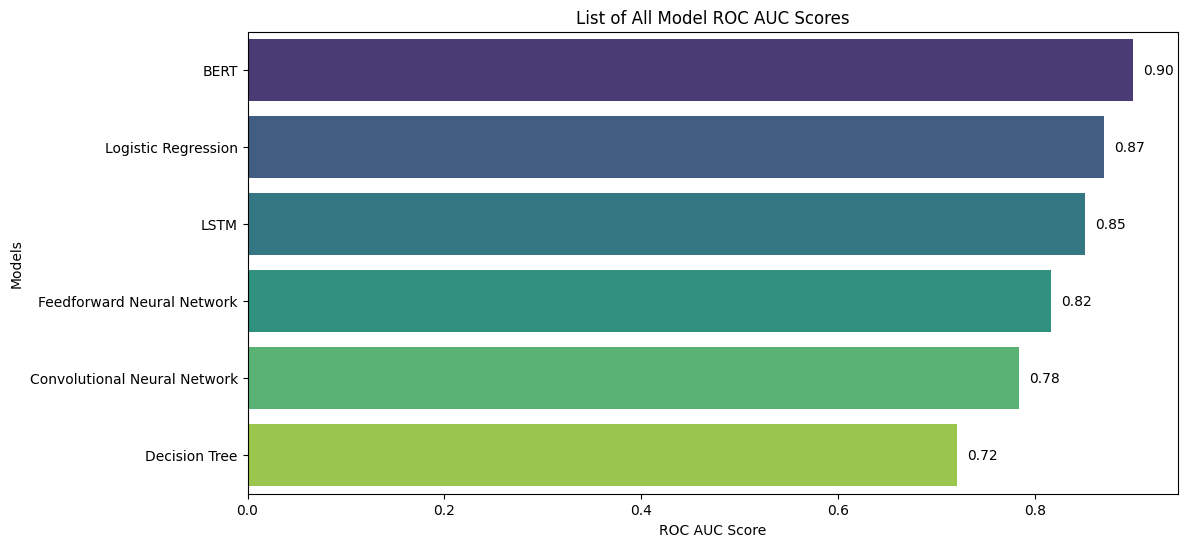

In [60]:
# Create a DataFrame to store the ROC AUC scores of all models
roc_auc_scores = pd.DataFrame({
    'Model': ['Feedforward Neural Network', 'Convolutional Neural Network', 'LSTM', 'BERT', 'Logistic Regression', 'Decision Tree'],
    'ROC AUC Score': [roc_auc_NN_model, roc_auc_CNN_model, roc_auc_LSTM_model, roc_auc_BERT_model, roc_auc_LR_model, roc_auc_DT_model]
})

# Sort the ROC AUC scores by descending order
roc_auc_scores = roc_auc_scores.sort_values(by='ROC AUC Score', ascending=False)
roc_auc_scores.reset_index(drop=True, inplace=True)
roc_auc_scores

# Plot the ROC AUC scores of all models
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='ROC AUC Score', y='Model', data=roc_auc_scores, palette='viridis')
plt.title('List of All Model ROC AUC Scores')
plt.xlabel('ROC AUC Score')
plt.ylabel('Models')

# Annotate each bar with the corresponding ROC AUC score value
for p in ax.patches:
    width = p.get_width()  # Get the width of the bar (ROC AUC score value)
    # Place text at the end of the bar
    plt.text(width + 0.01,  # x-coordinate for text
             p.get_y() + p.get_height() / 2,  # y-coordinate for text
             '{:1.2f}'.format(width),  # Text to display (ROC AUC score value)
             ha='left',  # Horizontal alignment
             va='center')  # Vertical alignment

plt.show()